# One hot encodeing values of the game 
This is a better way to reoresent the game and using CNN also helps model learn better


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from game_2048 import game_2048
import random
import copy
import matplotlib.pyplot as plt

/home/laserhammer/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
class Small_neural_net(nn.Module):
    def __init__(self):
        super(Small_neural_net,self).__init__()
        #input is 16x4x4
        self.conv1 = nn.Conv2d(16, 32, kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2, stride=1)
        self.droupout1 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(64, 200, kernel_size=2, stride=1)
        self.droupout2 = nn.Dropout(0.2)
        
        #200 x 1 x 1

        self.deep1 = nn.Linear(200,128)
        self.deep2 = nn.Linear(128,32)
        self.deep3 = nn.Linear(32,4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.droupout1(x)
        x = F.relu(self.conv3(x))
        x = self.droupout2(x)
        x = x.view(x.size(0), -1) 
        x = F.relu(self.deep1(x))
        x = F.relu(self.deep2(x))
        return self.deep3(x)  

In [3]:

def encode_state(matrix):
    encoded = np.zeros((16, 4, 4), dtype=np.float32)
    
    for i in range(4):
        for j in range(4):
            val = matrix[i][j]
            if val == 0:
                encoded[0, i, j] = 1
            else:
                power = int(np.log2(val))
                encoded[power, i, j] = 1
    
    return torch.tensor(encoded,dtype= torch.float32).unsqueeze(0)


def eta_greedy(greedy,action_values):
    action_values = action_values.tolist()
    actions = [0,1,2,3]
    if random.random()< greedy:
        return random.choice(actions)
    else:
        max_val = max(action_values)
        max_indices = [i for i, v in enumerate(action_values) if v == max_val]
        return random.choice(max_indices)

        




In [4]:
reward = 0
runs = 1000
model = Small_neural_net()
criteriation = nn.MSELoss()
game = game_2048()
buffer_game = game_2048()
model_eval = copy.deepcopy(model)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
gamma = 0.99
replay_memory = []
action = [0,1,2,3]
loss_his = []
reward_his = []

In [5]:
#filling the buffer
for i in range(500):
        #initialise the replay memory
        #run the model with copy to buffer up memory
        s_t = buffer_game.matrix.copy()
        a_t = random.choice(action)
        r_t = buffer_game.run(a_t)
        s_t_1 = buffer_game.matrix.copy()
        #store the replay in the memory
        replay_memory.append([s_t,a_t,r_t,s_t_1])
        if r_t == -1:
            buffer_game.initialise()
        

# Using stocastic gradient descent


In [6]:
batch_size = 10
batch_predict= []
batch_target = []


In [7]:
for run in tqdm(range(runs)):
    r_h =  []
    step = 0
    flag = 0
    game.initialise()
    while flag != -1:
        #train the model
        s_t = game.matrix.copy()
        #predict action value function
        q_t = model(encode_state(s_t))
        #choose an action based on action value functions predicted (throught eta greedy)
        a_t = eta_greedy(0.2,q_t)
        r_t = game.run(a_t)
        # override reward
        if(r_t == 0):
            r_t = -0.1
        
        s_t_1 = game.matrix.copy()
        #save the the experience in buffer 
        replay_memory.pop()
        replay_memory.append([s_t,a_t,r_t,s_t_1])

        #training
        #sample mini batch from replay
        experience = random.choice(replay_memory)
        if(step%2 == 0):
            model_eval = copy.deepcopy(model)
        with torch.no_grad():
            s_m,a_m,r_m,s_m_1 = experience
            q_t_1 = model_eval(encode_state(s_m_1))
            q_max = max(q_t_1[0])
            # if the next state in experience is terminal then there is no future reward
            # in this game to indicate terminal sate the reward outputs -1 
            # (this has to be treated as a flag and not a reward hence the override with 0)
            if(r_m == -1):
                y = -1
            else:
                y = r_m+ gamma*q_max
        # now that the predicted value has been calculated train the model
        #the target value is a tensor of size (1,4), so the update has to happen for the chosen action
        # taht is the action value update has to happen from the chosen action
        target = q_t.clone().detach()
        target[0,a_t] = y
        batch_target.append(target)
        batch_predict.append(q_t)
        # apply batch training take care of uneven batches
        j = (step+1)%batch_size
        if (j == 0 and len(batch_predict) == batch_size) or r_t == -1:
            target_tensor = torch.stack(batch_target)
            predict_tensor = torch.stack(batch_predict)
            loss = criteriation(predict_tensor,target_tensor)
            l = loss.item()
            r_h.append(r_t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_predict.clear()
            batch_target.clear()

        #append the loss and reward for model train evaluation
        flag = r_t
        # to see significant changes in training take sample model from time to time
        if(run == 0):
            untrained_model = copy.deepcopy(model)
        if(run == runs/2):
            fifty_model = copy.deepcopy(model)
        if(run == int(runs*3/4)):
            seventy_five = copy.deepcopy(model)
        step = step+1

    loss_his.append(l)
    reward_his.append(sum(r_h))
    


100%|██████████| 1000/1000 [2:00:08<00:00,  7.21s/it]    


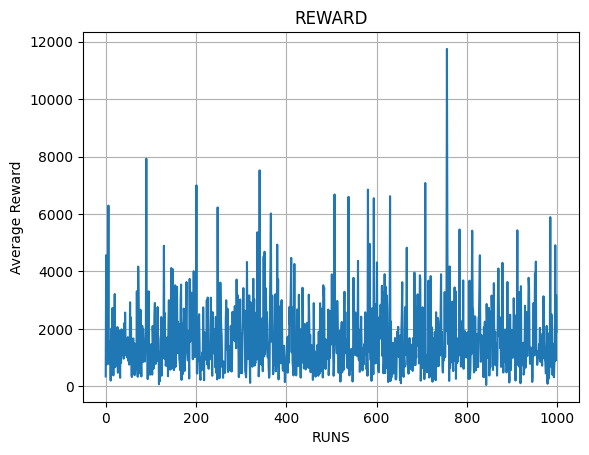

In [8]:
plt.xlabel("RUNS")
plt.ylabel("Average Reward")
plt.plot(reward_his)
plt.title("REWARD")
plt.grid(True)
plt.show()

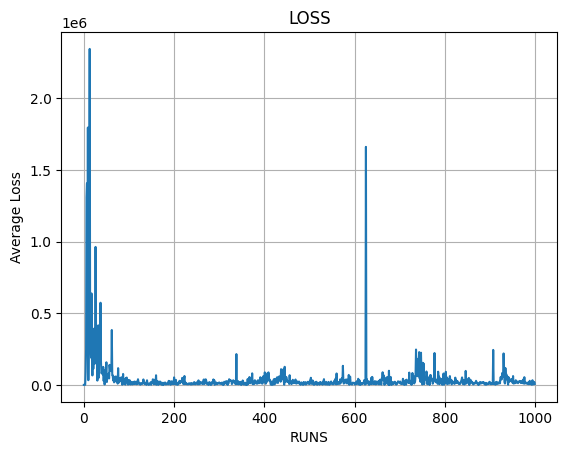

In [9]:
plt.xlabel("RUNS")
plt.ylabel("Average Loss")
plt.plot(loss_his)
plt.title("LOSS")
plt.grid(True)
plt.show()

In [10]:
def max_val(model, game, runs):
    max_vals = []
    for _ in tqdm(range(runs), desc="Evaluating max tile"):
        game.initialise()
        r_t = 0
        m = []  # store all max tiles for this run
        while r_t != -1 and r_t<=2048:
            s_t = game.matrix.copy()
            q_t = model(encode_state(s_t))
            a_t = eta_greedy(0.2, q_t)
            r_t = game.run(a_t)
            
            # track max tile
            max_tile = np.max(game.matrix)
            if max_tile>2048:
                continue
            m.append(max_tile)
        
        # record the highest tile in this run
        max_vals.append(max(m))

    return max_vals


In [18]:
max_un = max_val(untrained_model,game,1000)

Evaluating max tile: 100%|██████████| 1000/1000 [08:49<00:00,  1.89it/s]


In [19]:
trained_max_tile_value = max_val(model,game,1000)

Evaluating max tile: 100%|██████████| 1000/1000 [06:32<00:00,  2.55it/s]


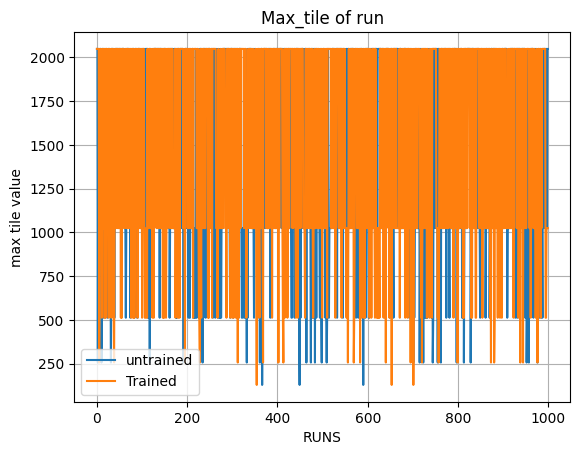

In [20]:
plt.xlabel("RUNS")
plt.ylabel("max tile value")
plt.plot(max_un,label = "untrained")
plt.plot(trained_max_tile_value,label = "Trained")
plt.title("Max_tile of run")
plt.grid(True)
plt.legend()
plt.show()

In [32]:
trained_max_tile_value.count(1024)

333

In [22]:
trained_max_tile_value.count(2048)

545

In [23]:
max_un.count(1024)

312

In [24]:
max_un.count(2048)

564

In [29]:
def eval(model,game,run):
    rewards = []
    for _ in tqdm(range(run)):
        game.initialise()
        r_t = 0
        ep_rewards = []
        while r_t != -1:
            s_t = game.matrix.copy()
            q_t = model(encode_state(s_t))
            a_t = eta_greedy(0.2, q_t)
            r_t = game.run(a_t)
            ep_rewards.append(r_t)
        rewards.append(np.mean(ep_rewards))
    return rewards

In [30]:
average_reward_untrained = eval(untrained_model,game,100)
fifty_model_average_reward = eval(fifty_model,game,100)
seventy_five_average_reward = eval(seventy_five,game,100)
reward = eval(model,game,100)


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


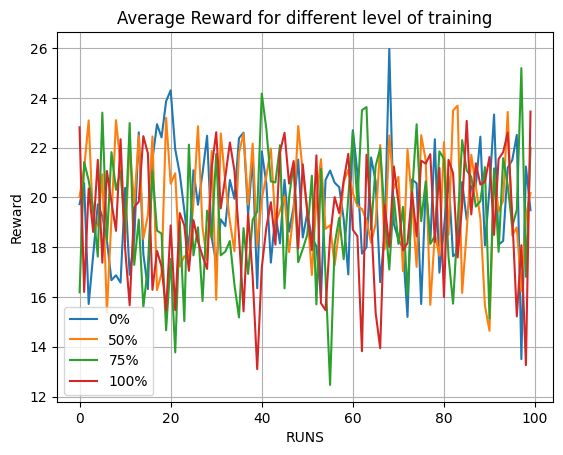

In [31]:
plt.xlabel("RUNS")
plt.ylabel("Reward")
plt.plot(average_reward_untrained,label = "0%")
plt.plot(fifty_model_average_reward,label = "50%")
plt.plot(seventy_five_average_reward,label = "75%")
plt.plot(reward,label = "100%")
plt.title("Average Reward for different level of training")
plt.grid(True)
plt.legend()
plt.show()